# Land Carbon Sink Analysis

Main notebook for the Land Carbon Sink Analysis project.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import numpy as np
import pandas as pd
import polars as pl
import os, sys
import geopandas as gpd

In [2]:
# directories
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

# Data import

In [3]:
# Natural Land Sink (0.5 arcdegrees)
natLandSink = xr.open_dataset(
    rawDir + "Land_carbon_uptake_DGVMs_gridded_GCB2024_2014-2023_mean.nc"
)

# Country mask
countryMask = xr.open_dataset(
    rawDir + "Country-mask_UNFCCC_layers-all-countries_grid-3600x1800.nc"
)

# Load datasets
country_codes = pd.read_excel(rawDir + "Country-codes_UNFCCC_199countries.xlsx")
country_codes["Numeric"] = country_codes["Numeric"].astype(int)

# Get list of country codes
ctrs_UNFCCC = country_codes["Alpha-3"]

# Read the CSV using pandas
cscc = pd.read_csv(
    rawDir + "statscc_SSP2_rcp60_constant_estimates_climensemble_hmqrs_lineartrend.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

## Natural Land Sink Country Attribution

In [4]:
# natLandSink.SLAND.plot()

In [5]:
# countryMask.land_fraction_global.plot()

In [6]:
# Regrid `countryMask` to match `natLandSink` coordinates
# regridder = xe.Regridder(countryMask, natLandSink, method="conservative")
# countryMask_regridded = regridder(countryMask)
# countryMask_regridded.to_netcdf(interimDir + "countryMask_regridded.nc")

In [7]:
# Load datasets
countryMask_regridded = xr.open_dataset(interimDir + "countryMask_regridded.nc")

# Inspect the coordinates
print(natLandSink.coords)
print(countryMask_regridded.coords)

Coordinates:
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Coordinates:
  * ISOcode  (ISOcode) float64 2kB 4.0 24.0 8.0 ... 716.0 9.999e+03 5.555e+03
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75


### Check Regridding

In [8]:
# Get lat and lon names
if "latitude" in natLandSink.dims:
    lat_name, lon_name = "latitude", "longitude"
else:
    lat_name, lon_name = "lat", "lon"

# Check that model grid and country grid agree
check_lat1 = np.max(
    np.abs(natLandSink[lat_name].values - countryMask_regridded[lat_name].values)
)
check_lon1 = np.max(
    np.abs(natLandSink[lon_name].values - countryMask_regridded[lon_name].values)
)
if check_lat1 > 0.001 or check_lon1 > 0.001:
    sys.exit("Coordinates do not agree")

# Re-index if there are small deviations in lat and lon
if (check_lat1 != 0) or (check_lon1 != 0):
    countryMask_regridded = countryMask_regridded.reindex(
        {lat_name: natLandSink[lat_name], lon_name: natLandSink[lon_name]},
        method="nearest",
    )

### Unit Conversion

In [9]:
# help(xe.util.cell_area)
# Compute grid areas (in km^2) for natLandSink
grid_areas_km2 = xe.util.cell_area(
    natLandSink, earth_radius=6371.0
)  # Earth radius in km

# Convert km^2 to m²
grid_areas_m2 = grid_areas_km2 * 1_000_000  # 1 km^2 = 1,000,000 m²

# Convert kgC/m²/s to GtC/year (global scale)
# Scale factor calculation
natLandSink = natLandSink.SLAND * 1e-12 * (60 * 60 * 24 * 365) * grid_areas_m2
natLandSink = natLandSink.fillna(0)

### Country Attribution

In [10]:
# Dictionary for storing country data
data_ctrs = dict()

# Loop over all country codes
for i, iso_alpha3 in enumerate(ctrs_UNFCCC):

    if np.mod(i, 20) == 0:
        print(f"  - processing country {i + 1} of {len(ctrs_UNFCCC)}")

    # Get numeric ISO code for the country
    iso_numeric = country_codes["Numeric"][
        country_codes["Alpha-3"] == iso_alpha3
    ].values[0]

    # Extract country mask for the current country
    mask = countryMask_regridded.sel(ISOcode=iso_numeric)

    # Weight by fraction of country-specific land area
    weights = mask.land_fraction / mask.land_fraction_global

    # Sum up the natural land sink for the selected country
    data_sel = (natLandSink * weights).sum((lat_name, lon_name))

    # Store results in dictionary
    data_ctrs[iso_alpha3] = data_sel.values

  - processing country 1 of 199
  - processing country 21 of 199
  - processing country 41 of 199
  - processing country 61 of 199
  - processing country 81 of 199
  - processing country 101 of 199
  - processing country 121 of 199
  - processing country 141 of 199
  - processing country 161 of 199
  - processing country 181 of 199


In [11]:
##### Add fluxes in ocean grid cells to closest county ####

data_ocean = natLandSink.where(countryMask_regridded.land_fraction_global == 0)
data_ocean = data_ocean.where(data_ocean != 0)

# Get 2D arrays with latitudes and longitudes and only keep country areas (where land_fraction exists)
LON, LAT = np.meshgrid(countryMask_regridded.lon, countryMask_regridded.lat)

# Mask out ocean areas where land_fraction is NaN (i.e., only keep country areas)
LAT[countryMask_regridded.land_fraction_global == 0] = np.nan
LON[countryMask_regridded.land_fraction_global == 0] = np.nan

# Convert latitudes and longitudes to radians for distance calculation
LAT_rad = LAT * np.pi / 180
LON_rad = LON * np.pi / 180

In [12]:
# Loop over all ocean grid cells to assign values to closest country cells
for i_lat in range(len(data_ocean.lat)):
    for i_lon in range(len(data_ocean.lon)):
        # Read land sink data for the specific grid cell
        data_sel = data_ocean.isel(lat=i_lat, lon=i_lon)

        # Only process ocean grid cells with non-zero land sink values
        if not np.isnan(data_sel):

            # Get latitude and longitude of the ocean grid cell in radians
            lat_ocean = data_sel.lat.item() * np.pi / 180
            lon_ocean = data_sel.lon.item() * np.pi / 180

            # Calculate the argument for arccos
            argument = np.sin(lat_ocean) * np.sin(LAT_rad) + np.cos(lat_ocean) * np.cos(
                LAT_rad
            ) * np.cos(lon_ocean - LON_rad)
            argument = np.clip(argument, -1, 1)  # Clip to avoid invalid values

            # Calculate distances
            distance = np.arccos(argument)

            # Find the closest land grid cell(s)
            index_closest = np.argwhere(distance == np.nanmin(distance))

            for ind in index_closest:
                # Get latitude and longitude of the closest grid cell
                lat_sel = LAT[ind[0], ind[1]]
                lon_sel = LON[ind[0], ind[1]]

                # Select the land_fraction at the specified lat, lon
                land_fraction_at_point = countryMask_regridded.sel(
                    lat=lat_sel, lon=lon_sel
                ).land_fraction

                # Find the index where land_fraction is non-zero
                non_zero_index = np.where(land_fraction_at_point.values != 0)[0]

                if len(non_zero_index) == 0:
                    print(f"No country found for lat={lat_sel}, lon={lon_sel}")
                    continue  # Skip this point
                elif len(non_zero_index) > 1:
                    # Assign to the country with the largest land fraction
                    largest_fraction_index = non_zero_index[
                        land_fraction_at_point.values[non_zero_index].argmax()
                    ]
                    iso_code = countryMask_regridded.ISOcode[
                        largest_fraction_index
                    ].values
                    print(
                        f"Multiple countries found for lat={lat_sel}, lon={lon_sel}. "
                        f"Assigned to ISO Code {iso_code} (largest land fraction)."
                    )
                else:
                    # Single country case
                    iso_code = countryMask_regridded.ISOcode[non_zero_index[0]].values
                    print(f"ISO Code {iso_code} found for lat={lat_sel}, lon={lon_sel}")

                # Retrieve country name for the ISO code
                ctr_name = country_codes["Alpha-3"][
                    country_codes["Numeric"] == iso_code
                ].values[0]

                # Add the ocean grid cell's natural land sink value to the closest country's data
                data_ctrs[ctr_name] += data_sel.values / len(index_closest)

ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-84.75, lon=-165.25
ISO Code 5555.0 found for lat=-85.25, lon=-159.75
ISO Code 5555.0 found for lat=-85.25, lon=-159.25
ISO Code 5555.0 found for lat=-85.25, lon=-158.75
ISO Code 5555.0 found for lat=-85.25, lon=-158.25
ISO Code 5555.0 found for lat=-85.25, lon=-157.75
ISO Code 5555.0 found for lat=-85.25, lon=-157.25
ISO Code 5555.0 found for lat=-85.25, lon=-156.75
ISO Code 5555.0 found for lat=-85.25, lon=-156.25
ISO Code 5555.0 found for lat=-84.75, lon=-150.75
ISO Code 5555.0 found for lat=-84.75, lon=-150.75


### Save results

In [13]:
# Convert data_ctrs to a DataFrame with country names as the index
data_ctrs_df = pd.DataFrame(list(data_ctrs.items()), columns=["iso", "SLAND"])

# Sort the DataFrame by 'Country' column if needed
data_ctrs_df = data_ctrs_df.sort_values("SLAND").reset_index(drop=True)

# Add units to the DataFrame and save to Excel
data_ctrs_df.to_excel(processedDir + "land_sink_by_country.xlsx", index=False)

data_ctrs_df.to_csv(processedDir + "land_sink_by_country.csv")

### Check total sum and country level sums

In [14]:
total_land_sink_Gt_per_yr = data_ctrs_df["SLAND"].sum()
Sland_sum = (natLandSink).sum(dim=["lat", "lon"]).item()
print(
    "Country Sum Land Sink (Gt per yr) conservative method:", total_land_sink_Gt_per_yr
)

print("Total Grid Cell Sum Land Sink (Gt per yr) :", Sland_sum)

Country Sum Land Sink (Gt per yr) conservative method: 4.19349973288415
Total Grid Cell Sum Land Sink (Gt per yr) : 4.193499732884147


# Land Use Change with Excel table

In [15]:
# Load the Excel file
xls = pd.ExcelFile(rawDir + "National_LandUseChange_Carbon_Emissions_2024v1.0.xlsx")

# Define the sheets and model names
sheets = {1: "BLUE", 2: "HC2023", 3: "OSCAR", 4: "LUCE"}

# Initialize an empty DataFrame to store results
elu_xlsx = []

# Process each sheet
for sheet_idx, model_name in sheets.items():
    # Load the sheet into a DataFrame
    df = xls.parse(sheet_idx, header=None)

    # Extract the country names (row 8, starting from column B)
    countries = df.iloc[7, 1:].values

    # Extract the years and data (from row 9 onward, column A contains years)
    data = df.iloc[8:, 1:].values
    # Extract the years (column A) and convert to numeric, coercing errors
    years = pd.to_numeric(df.iloc[8:, 0], errors="coerce")

    # Filter rows for years 2013–2022
    year_mask = (years >= 2014) & (years <= 2023)
    data_filtered = data[year_mask]

    # Calculate the average for each country
    averages = data_filtered.mean(axis=0)

    # Append to the results list
    for country, avg in zip(countries, averages):
        elu_xlsx.append({"Country": country, "Model": model_name, "ELUC": avg})

# Convert the results to a DataFrame
eluc_model_df = pd.DataFrame(elu_xlsx)

# List of regions to exclude
exclude_countries = ["OTHER", "DISPUTED", "Global", "EU27"]

# Filter the DataFrame to exclude these countries
eluc_model_df_filtered = eluc_model_df[
    ~eluc_model_df["Country"].isin(exclude_countries)
]

# Optionally reset the index if needed
eluc_model_df_filtered = eluc_model_df_filtered.reset_index(drop=True)

# View the filtered DataFrame
print(eluc_model_df_filtered)

# Group by Country and calculate the mean across model types
eluc_average_df = eluc_model_df_filtered.groupby("Country", as_index=False)[
    "ELUC"
].mean()

# Convert from Million tons of carbon to GtC/yr
eluc_average_df["ELUC"] = eluc_average_df["ELUC"] / 1000
print(eluc_average_df)

         Country Model       ELUC
0    Afghanistan  BLUE   1.815956
1        Albania  BLUE   0.068230
2        Algeria  BLUE   0.657036
3        Andorra  BLUE  -0.001818
4         Angola  BLUE  18.725578
..           ...   ...        ...
783    Venezuela  LUCE   1.764432
784     Viet Nam  LUCE  32.497068
785        Yemen  LUCE  -0.106710
786       Zambia  LUCE  14.355542
787     Zimbabwe  LUCE  -0.948614

[788 rows x 3 columns]
         Country      ELUC
0    Afghanistan  0.000958
1        Albania -0.000026
2        Algeria  0.000151
3        Andorra -0.000002
4         Angola  0.025620
..           ...       ...
192    Venezuela  0.006367
193     Viet Nam  0.027227
194        Yemen -0.000031
195       Zambia  0.014064
196     Zimbabwe  0.001679

[197 rows x 2 columns]


### Add Iso column

In [16]:
iso_mapping = {
    "Afghanistan": "AFG",
    "Albania": "ALB",
    "Algeria": "DZA",
    "Andorra": "AND",
    "Angola": "AGO",
    "Antigua and Barbuda": "ATG",
    "Argentina": "ARG",
    "Armenia": "ARM",
    "Australia": "AUS",
    "Austria": "AUT",
    "Azerbaijan": "AZE",
    "Bahamas": "BHS",
    "Bahrain": "BHR",
    "Bangladesh": "BGD",
    "Barbados": "BRB",
    "Belarus": "BLR",
    "Belgium": "BEL",
    "Belize": "BLZ",
    "Benin": "BEN",
    "Bhutan": "BTN",
    "Bolivia": "BOL",
    "Bosnia and Herzegovina": "BIH",
    "Botswana": "BWA",
    "Brazil": "BRA",
    "Brunei Darussalam": "BRN",
    "Bulgaria": "BGR",
    "Burkina Faso": "BFA",
    "Burundi": "BDI",
    "Cambodia": "KHM",
    "Cameroon": "CMR",
    "Canada": "CAN",
    "Cape Verde": "CPV",
    "Central African Republic": "CAF",
    "Chad": "TCD",
    "Chile": "CHL",
    "China": "CHN",
    "Colombia": "COL",
    "Comoros": "COM",
    "Congo": "COG",
    "Cook Islands": "COK",
    "Costa Rica": "CRI",
    "Croatia": "HRV",
    "Cuba": "CUB",
    "Cyprus": "CYP",
    "Czechia": "CZE",
    "Côte d'Ivoire": "CIV",
    "Democratic Republic of the Congo": "COD",
    "Denmark": "DNK",
    "Djibouti": "DJI",
    "Dominica": "DMA",
    "Dominican Republic": "DOM",
    "Ecuador": "ECU",
    "Egypt": "EGY",
    "El Salvador": "SLV",
    "Equatorial Guinea": "GNQ",
    "Eritrea": "ERI",
    "Estonia": "EST",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Fiji": "FJI",
    "Finland": "FIN",
    "France": "FRA",
    "Gabon": "GAB",
    "Gambia": "GMB",
    "Georgia": "GEO",
    "Germany": "DEU",
    "Ghana": "GHA",
    "Greece": "GRC",
    "Grenada": "GRD",
    "Guatemala": "GTM",
    "Guinea": "GIN",
    "Guinea-Bissau": "GNB",
    "Guyana": "GUY",
    "Haiti": "HTI",
    "Honduras": "HND",
    "Hungary": "HUN",
    "Iceland": "ISL",
    "India": "IND",
    "Indonesia": "IDN",
    "Iran": "IRN",
    "Iraq": "IRQ",
    "Ireland": "IRL",
    "Israel": "ISR",
    "Italy": "ITA",
    "Jamaica": "JAM",
    "Japan": "JPN",
    "Jordan": "JOR",
    "Kazakhstan": "KAZ",
    "Kenya": "KEN",
    "Kiribati": "KIR",
    "Kuwait": "KWT",
    "Kyrgyzstan": "KGZ",
    "Laos": "LAO",
    "Latvia": "LVA",
    "Lebanon": "LBN",
    "Lesotho": "LSO",
    "Liberia": "LBR",
    "Libya": "LBY",
    "Liechtenstein": "LIE",
    "Lithuania": "LTU",
    "Luxembourg": "LUX",
    "Madagascar": "MDG",
    "Malawi": "MWI",
    "Malaysia": "MYS",
    "Maldives": "MDV",
    "Mali": "MLI",
    "Malta": "MLT",
    "Marshall Islands": "MHL",
    "Mauritania": "MRT",
    "Mauritius": "MUS",
    "Mexico": "MEX",
    "Micronesia (Federated States of)": "FSM",
    "Moldova": "MDA",
    "Monaco": "MCO",
    "Mongolia": "MNG",
    "Montenegro": "MNE",
    "Morocco": "MAR",
    "Mozambique": "MOZ",
    "Myanmar": "MMR",
    "Namibia": "NAM",
    "Nauru": "NRU",
    "Nepal": "NPL",
    "Netherlands": "NLD",
    "New Zealand": "NZL",
    "Nicaragua": "NIC",
    "Niger": "NER",
    "Nigeria": "NGA",
    "Niue": "NIU",
    "North Korea": "PRK",
    "North Macedonia": "MKD",
    "Norway": "NOR",
    "Oman": "OMN",
    "Pakistan": "PAK",
    "Palau": "PLW",
    "Panama": "PAN",
    "Papua New Guinea": "PNG",
    "Paraguay": "PRY",
    "Peru": "PER",
    "Philippines": "PHL",
    "Poland": "POL",
    "Portugal": "PRT",
    "Qatar": "QAT",
    "Romania": "ROU",
    "Russia": "RUS",
    "Rwanda": "RWA",
    "Saint Kitts and Nevis": "KNA",
    "Saint Lucia": "LCA",
    "Saint Vincent and the Grenadines": "VCT",
    "Samoa": "WSM",
    "San Marino": "SMR",
    "Sao Tome and Principe": "STP",
    "Saudi Arabia": "SAU",
    "Senegal": "SEN",
    "Serbia": "SRB",
    "Seychelles": "SYC",
    "Sierra Leone": "SLE",
    "Singapore": "SGP",
    "Slovakia": "SVK",
    "Slovenia": "SVN",
    "Solomon Islands": "SLB",
    "Somalia": "SOM",
    "South Africa": "ZAF",
    "South Korea": "KOR",
    "South Sudan": "SSD",
    "Spain": "ESP",
    "Sri Lanka": "LKA",
    "State of Palestine": "PSE",
    "Sudan": "SDN",
    "Suriname": "SUR",
    "Sweden": "SWE",
    "Switzerland": "CHE",
    "Syria": "SYR",
    "Tajikistan": "TJK",
    "Tanzania": "TZA",
    "Thailand": "THA",
    "Timor-Leste": "TLS",
    "Togo": "TGO",
    "Tonga": "TON",
    "Trinidad and Tobago": "TTO",
    "Tunisia": "TUN",
    "Turkmenistan": "TKM",
    "Tuvalu": "TUV",
    "Türkiye": "TUR",
    "USA": "USA",
    "Uganda": "UGA",
    "Ukraine": "UKR",
    "United Arab Emirates": "ARE",
    "United Kingdom": "GBR",
    "Uruguay": "URY",
    "Uzbekistan": "UZB",
    "Vanuatu": "VUT",
    "Vatican City": "VAT",
    "Venezuela": "VEN",
    "Viet Nam": "VNM",
    "Yemen": "YEM",
    "Zambia": "ZMB",
    "Zimbabwe": "ZWE",
    "Anguilla": "AIA",
    "Aruba": "ABW",
    "Bermuda": "BMU",
    "Bonaire, Saint Eustatius and Saba": "BES",
    "British Virgin Islands": "VGB",
    "Curaçao": "CUW",
    "Faeroe Islands": "FRO",
    "French Polynesia": "PYF",
    "Greenland": "GRL",
    "Hong Kong": "HKG",
    "Kosovo": "XKX",  # Not officially recognized, but commonly used
    "Macao": "MAC",
    "Montserrat": "MSR",
    "New Caledonia": "NCL",
    "Saint Helena": "SHN",
    "Sint Maarten (Dutch part)": "SXM",
    "Saint Pierre and Miquelon": "SPM",
    "Taiwan": "TWN",
    "Turks and Caicos Islands": "TCA",
    "Wallis and Futuna Islands": "WLF",
}

In [17]:
# Add ISO code column
eluc_average_df["iso"] = eluc_average_df["Country"].map(iso_mapping)

# Save to a new file or inspect the resulting DataFrame
eluc_average_df.to_csv(
    processedDir + "eluc_country_mean_across_models.csv", index=False
)

# Print the resulting table
print(eluc_average_df)

         Country      ELUC  iso
0    Afghanistan  0.000958  AFG
1        Albania -0.000026  ALB
2        Algeria  0.000151  DZA
3        Andorra -0.000002  AND
4         Angola  0.025620  AGO
..           ...       ...  ...
192    Venezuela  0.006367  VEN
193     Viet Nam  0.027227  VNM
194        Yemen -0.000031  YEM
195       Zambia  0.014064  ZMB
196     Zimbabwe  0.001679  ZWE

[197 rows x 3 columns]


## Fossil and Industry CO2 emissions

In [18]:
# Load only Sheet 1
xls_fossil = pd.ExcelFile(rawDir + "National_Fossil_Carbon_Emissions_2024v1.0.xlsx")
df_sheet1 = xls_fossil.parse(
    sheet_name=1, header=None
)  # Assuming sheet index 0 is sheet 1

# Extract country names (row 12, starting from column B)
countries = df_sheet1.iloc[11, 1:].values

# Extract years and data
years = pd.to_numeric(
    df_sheet1.iloc[12:, 0].values, errors="coerce"
)  # Convert years to numeric, handle non-numeric
data = df_sheet1.iloc[12:, 1:].apply(
    pd.to_numeric, errors="coerce"
)  # Convert data to numeric

# Filter rows for years 2013–2022
year_mask = (years >= 2014) & (years <= 2023)
data_filtered = data[year_mask]

# Calculate the average for each country
fossil_averages = data_filtered.mean(axis=0).values

# Create a DataFrame with the results
fossil_df = pd.DataFrame({"Country": countries, "EFOS": fossil_averages})

# Drop rows with missing country or fossil data (optional)
# fossil_df.dropna(subset=['Country', 'Fossil'], inplace=True)

# Convert from Million tons of carbon to GtC/yr
fossil_df["EFOS"] = fossil_df["EFOS"] / 1000

# Normalize country names in the dataset
fossil_df["Country"] = fossil_df["Country"].str.strip()

# List of regions to exclude
exclude_countries_fossil = [
    "KP Annex B",
    "Non KP Annex B",
    "OECD",
    "Non-OECD",
    "EU27",
    "Africa",
    "Asia",
    "Central America",
    "Europe",
    "Middle East",
    "North America",
    "Oceania",
    "South America",
    "Bunkers",
    "Statistical Difference",
    "World",
]

# Filter the DataFrame to exclude these countries
efos_df = fossil_df[~fossil_df["Country"].isin(exclude_countries_fossil)]

# Optionally reset the index if needed
efos_df = efos_df.reset_index(drop=True)

# View the filtered DataFrame
print(efos_df)

# Add ISO code column
efos_df["iso"] = efos_df["Country"].map(iso_mapping)

print(efos_df)

                       Country      EFOS
0                  Afghanistan  0.002895
1                      Albania  0.001365
2                      Algeria  0.041960
3                      Andorra  0.000122
4                       Angola  0.004369
..                         ...       ...
209                   Viet Nam  0.077750
210  Wallis and Futuna Islands  0.000007
211                      Yemen  0.003164
212                     Zambia  0.001893
213                   Zimbabwe  0.002849

[214 rows x 2 columns]
                       Country      EFOS  iso
0                  Afghanistan  0.002895  AFG
1                      Albania  0.001365  ALB
2                      Algeria  0.041960  DZA
3                      Andorra  0.000122  AND
4                       Angola  0.004369  AGO
..                         ...       ...  ...
209                   Viet Nam  0.077750  VNM
210  Wallis and Futuna Islands  0.000007  WLF
211                      Yemen  0.003164  YEM
212                     

In [19]:
# Check for countries that did not match
missing_countries = efos_df[efos_df["iso"].isna()]["Country"].unique()
print("Countries without ISO codes:", missing_countries)

Countries without ISO codes: []


## Inclusive Wealth Calculations

### Country Social Cost of Carbon

In [20]:
# Filter the DataFrame for rows where 'dr' is '2p5'
cscc_dr_2p5 = cscc[cscc["dr"] == "2p5"].iloc[:, :8]
# Reset index
cscc_dr_2p5 = cscc_dr_2p5.reset_index(drop=True)

# Display the filtered DataFrame
print(cscc_dr_2p5)

         mean       10%       25%       50%       75%       90%  \
0    0.189751  0.097240  0.113365  0.151029  0.263093  0.349273   
1    0.506439  0.372660  0.413813  0.480565  0.583711  0.663359   
2    0.010711  0.005458  0.007455  0.009342  0.013954  0.017916   
3    1.355618  1.022255  1.102007  1.260093  1.584158  1.807030   
4    0.603128  0.291389  0.449100  0.583355  0.760296  0.912733   
..        ...       ...       ...       ...       ...       ...   
165  0.001515  0.001036  0.001174  0.001415  0.001817  0.002131   
166  0.513020  0.397119  0.429131  0.491674  0.577183  0.658199   
167  0.856749  0.654120  0.709885  0.807980  0.971441  1.127560   
168  0.477014  0.352803  0.393923  0.460681  0.534962  0.628213   
169  0.078411  0.059592  0.065213  0.074987  0.087461  0.102336   

                ID  iso  
0    NA_NA_2p5_AFG  AFG  
1    NA_NA_2p5_AGO  AGO  
2    NA_NA_2p5_ALB  ALB  
3    NA_NA_2p5_ARE  ARE  
4    NA_NA_2p5_ARG  ARG  
..             ...  ...  
165  NA_NA_2p

### Import Natural Land sink values Dorgeist

In [21]:
# Read Dorgeist data
sland_df_dor = pd.read_csv(processedDir + "land_sink_by_country_dor.csv")

In [22]:
# Make sure positive values are flux from atmosphere to land
# sland_df is correct the others need to be adjusted

# Create a copy of the dataframe


sland_df = data_ctrs_df.copy()

# Create a copy of the dataframe
eluc_reversed_df = eluc_average_df.copy()


# Multiply the ELUC column by -1


eluc_reversed_df["ELUC"] = eluc_reversed_df["ELUC"] * -1

# Create a copy of the dataframe
efos_reversed_df = efos_df.copy()
# Multiply the EFOS column by -1
efos_reversed_df["EFOS"] = efos_reversed_df["EFOS"] * -1

# Create a copy of the dataframe
sland_reversed_df_dor = sland_df_dor.copy()
# Multiply the SLAND_dor column by -1
sland_reversed_df_dor["SLAND_dor"] = sland_reversed_df_dor["SLAND_dor"] * -1

In [23]:
# Merge the dataframes on the 'iso' variable
merged_df = pd.merge(cscc_dr_2p5, sland_df, on="iso", how="outer")  # inner join
merged_df = pd.merge(
    merged_df, sland_reversed_df_dor, on="iso", how="outer"
)  # inner join
merged_df = pd.merge(merged_df, eluc_reversed_df, on="iso", how="outer")
merged_df = pd.merge(merged_df, efos_reversed_df, on="iso", how="outer")

# Select only the required columns in the specified order
columns_to_keep = ["iso", "mean", "SLAND", "SLAND_dor", "ELUC", "EFOS"]
final_df = merged_df[columns_to_keep].copy()

# Rename the 'mean' column to 'CSCC'
final_df.rename(columns={"mean": "CSCC"}, inplace=True)

In [24]:
print(final_df)
# Save to a new file or inspect the resulting DataFrame
final_df.to_csv(processedDir + "final_df.csv", index=False)

     iso      CSCC                  SLAND  SLAND_dor      ELUC      EFOS
0    ABW       NaN                    NaN        NaN       NaN -0.000241
1    AFG  0.189751   0.002902048233193369   0.006290 -0.000958 -0.002895
2    AGO  0.506439    0.05828890324538212   0.044797 -0.025620 -0.004369
3    AIA       NaN                    NaN        NaN       NaN -0.000038
4    ALB  0.010711  0.0013901095367767659   0.000747  0.000026 -0.001365
..   ...       ...                    ...        ...       ...       ...
215  XKX       NaN                    NaN        NaN       NaN -0.002238
216  YEM  0.513020  0.0012196978017220779   0.002181  0.000031 -0.003164
217  ZAF  0.856749   0.015270747167251995   0.016986  0.000259 -0.119098
218  ZMB  0.477014   0.031542078434239645   0.022222 -0.014064 -0.001893
219  ZWE  0.078411   0.009537904847010484   0.006959 -0.001679 -0.002849

[220 rows x 6 columns]


In [25]:
final_df = pd.read_csv(processedDir + "final_df.csv")

# Wealth Computations

### Prepare fluxes

In [26]:
# Net fluxes
final_df["F_ab"] = final_df["ELUC"] + final_df["SLAND"]  # Net land flux
final_df["F_ac"] = final_df["ELUC"] + final_df["EFOS"]  # Net anthropogenic flux
final_df["F_abc"] = (
    final_df["ELUC"] + final_df["SLAND"] + final_df["EFOS"]
)  # Combined net flux

# Net fluxes Dorgeist
final_df["F_ab_dor"] = final_df["ELUC"] + final_df["SLAND_dor"]  # Net land flux
final_df["F_abc_dor"] = (
    final_df["ELUC"] + final_df["SLAND_dor"] + final_df["EFOS"]
)  # Combined net flux

## Prepare total sums

In [27]:
# Calculate the global sums
SCC = final_df["CSCC"].sum(skipna=True)

# Print the results
print(f"SCC (Sum of 'mean'): {SCC}")

SCC (Sum of 'mean'): 227.09444261326377


## Calculate Wealth Metrix for each flux

In [28]:
# Define a list of fluxes
flux_columns = [
    "SLAND",
    "SLAND_dor",
    "ELUC",
    "EFOS",
    "F_ab",
    "F_ab_dor",
    "F_ac",
    "F_abc",
    "F_abc_dor",
]

# Add new columns for wealth metrics
for flux in flux_columns:
    # Global wealth contribution
    final_df[f"{flux}_global"] = final_df[flux] * SCC

    # Domestic wealth contribution
    final_df[f"{flux}_domestic"] = final_df[flux] * final_df["CSCC"]

    # Out wealth contribution
    final_df[f"{flux}_out"] = final_df[f"{flux}_global"] - final_df[f"{flux}_domestic"]

    # In wealth contribution
    # Sum all fluxes globally except for the current country
    flux_global = final_df[flux].sum(skipna=True)
    final_df[f"{flux}_in"] = (flux_global - final_df[flux]) * final_df["CSCC"]

    # Net Wealth Transfer

    final_df[f"{flux}_NWT"] = final_df[f"{flux}_out"] - final_df[f"{flux}_in"]

In [29]:
wealth_df = final_df.copy()
wealth_df.to_csv(processedDir + "wealth_calculations_df.csv", index=False)
wealth_df.to_excel(processedDir + "wealth_calculations_df.xlsx", index=False)

# Plots

## Introduction: Explaining the Data
### Overview of Carbon Fluxes (SLAND, ELUC, EFOS)

In [30]:
# Example ISO to Continent Mapping (add all your countries)
iso_to_continent = {
    "AFG": "Asia",
    "AGO": "Africa",
    "ALB": "Europe",
    "ARE": "Asia",
    "ARG": "South America",
    "ARM": "Asia",
    "AUS": "Oceania",
    "AUT": "Europe",
    "AZE": "Asia",
    "BDI": "Africa",
    "BEL": "Europe",
    "BEN": "Africa",
    "BFA": "Africa",
    "BGD": "Asia",
    "BGR": "Europe",
    "BHS": "North America",
    "BIH": "Europe",
    "BLR": "Europe",
    "BLZ": "North America",
    "BOL": "South America",
    "BRA": "South America",
    "BRN": "Asia",
    "BTN": "Asia",
    "BWA": "Africa",
    "CAF": "Africa",
    "CAN": "North America",
    "CHE": "Europe",
    "CHL": "South America",
    "CHN": "Asia",
    "CIV": "Africa",
    "CMR": "Africa",
    "COD": "Africa",
    "COG": "Africa",
    "COL": "South America",
    "COM": "Africa",
    "CPV": "Africa",
    "CRI": "North America",
    "CUB": "North America",
    "CYP": "Europe",
    "CZE": "Europe",
    "DEU": "Europe",
    "DJI": "Africa",
    "DNK": "Europe",
    "DOM": "North America",
    "DZA": "Africa",
    "ECU": "South America",
    "EGY": "Africa",
    "ERI": "Africa",
    "ESP": "Europe",
    "EST": "Europe",
    "ETH": "Africa",
    "FIN": "Europe",
    "FJI": "Oceania",
    "FRA": "Europe",
    "GAB": "Africa",
    "GBR": "Europe",
    "GEO": "Asia",
    "GHA": "Africa",
    "GIN": "Africa",
    "GMB": "Africa",
    "GNB": "Africa",
    "GNQ": "Africa",
    "GRC": "Europe",
    "GTM": "North America",
    "GUY": "South America",
    "HND": "North America",
    "HRV": "Europe",
    "HTI": "North America",
    "HUN": "Europe",
    "IDN": "Asia",
    "IND": "Asia",
    "IRL": "Europe",
    "IRN": "Asia",
    "IRQ": "Asia",
    "ISL": "Europe",
    "ISR": "Asia",
    "ITA": "Europe",
    "JAM": "North America",
    "JOR": "Asia",
    "JPN": "Asia",
    "KAZ": "Asia",
    "KEN": "Africa",
    "KGZ": "Asia",
    "KHM": "Asia",
    "KOR": "Asia",
    "KWT": "Asia",
    "LAO": "Asia",
    "LBN": "Asia",
    "LBR": "Africa",
    "LBY": "Africa",
    "LKA": "Asia",
    "LSO": "Africa",
    "LTU": "Europe",
    "LUX": "Europe",
    "LVA": "Europe",
    "MAR": "Africa",
    "MDA": "Europe",
    "MDG": "Africa",
    "MEX": "North America",
    "MKD": "Europe",
    "MLI": "Africa",
    "MMR": "Asia",
    "MNE": "Europe",
    "MNG": "Asia",
    "MOZ": "Africa",
    "MRT": "Africa",
    "MUS": "Africa",
    "MWI": "Africa",
    "MYS": "Asia",
    "NAM": "Africa",
    "NER": "Africa",
    "NGA": "Africa",
    "NIC": "North America",
    "NLD": "Europe",
    "NOR": "Europe",
    "NPL": "Asia",
    "NZL": "Oceania",
    "OMN": "Asia",
    "PAK": "Asia",
    "PAN": "North America",
    "PER": "South America",
    "PHL": "Asia",
    "PNG": "Oceania",
    "POL": "Europe",
    "PRT": "Europe",
    "PRY": "South America",
    "QAT": "Asia",
    "ROU": "Europe",
    "RUS": "Europe",
    "RWA": "Africa",
    "SAU": "Asia",
    "SDN": "Africa",
    "SEN": "Africa",
    "SLB": "Oceania",
    "SLE": "Africa",
    "SLV": "North America",
    "SOM": "Africa",
    "SRB": "Europe",
    "STP": "Africa",
    "SUR": "South America",
    "SVK": "Europe",
    "SVN": "Europe",
    "SWE": "Europe",
    "SWZ": "Africa",
    "SYR": "Asia",
    "TCD": "Africa",
    "TGO": "Africa",
    "THA": "Asia",
    "TJK": "Asia",
    "TKM": "Asia",
    "TTO": "North America",
    "TUN": "Africa",
    "TUR": "Asia",
    "TZA": "Africa",
    "UGA": "Africa",
    "UKR": "Europe",
    "URY": "South America",
    "USA": "North America",
    "UZB": "Asia",
    "VCT": "North America",
    "VEN": "South America",
    "VNM": "Asia",
    "VUT": "Oceania",
    "WSM": "Oceania",
    "YEM": "Asia",
    "ZAF": "Africa",
    "ZMB": "Africa",
    "ZWE": "Africa",
    "ABW": "North America",
    "AIA": "North America",
    "AND": "Europe",
    "BES": "North America",
    "BMU": "North America",
    "CUW": "North America",
    "FRO": "Europe",
    "GGY": "Europe",
    "IMN": "Europe",
    "JEY": "Europe",
    "MAC": "Asia",
    "NCL": "Oceania",
    "SHN": "Africa",
    "SXM": "North America",
    "SPM": "North America",
    "TWN": "Asia",
    "TCA": "North America",
    "WLF": "Oceania",
}

# Map countries to continents
wealth_df["Continent"] = wealth_df["iso"].map(iso_to_continent)

# Aggregate data by continent
continent_df = wealth_df.groupby("Continent").sum().reset_index()

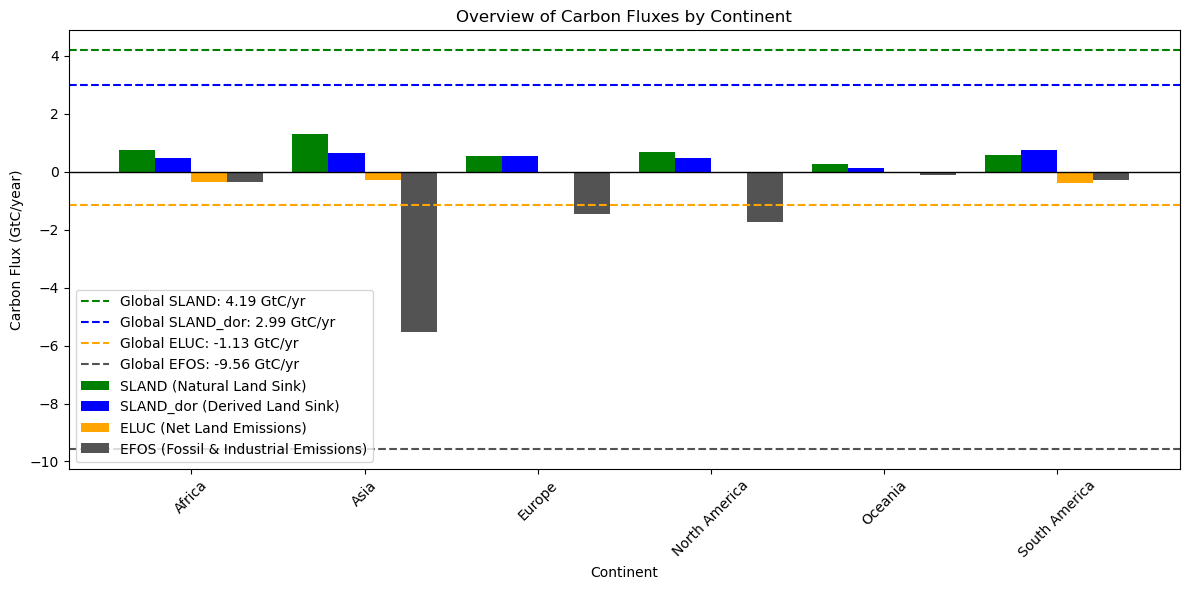

In [31]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar settings
bar_width = 0.25  # Width of each bar
spacing = 0.2  # Reduced space between groups of bars for each continent

# Adjusted X positions with smaller spacing
x = np.arange(len(continent_df["Continent"])) * (4 * bar_width + spacing)

# Plot each flux with an offset
ax.bar(
    x - 1.5 * bar_width,
    continent_df["SLAND"],
    width=bar_width,
    label="SLAND (Natural Land Sink)",
    color="green",
)
ax.bar(
    x - 0.5 * bar_width,
    continent_df["SLAND_dor"],
    width=bar_width,
    label="SLAND_dor (Derived Land Sink)",
    color="blue",
)
ax.bar(
    x + 0.5 * bar_width,
    continent_df["ELUC"],
    width=bar_width,
    label="ELUC (Net Land Emissions)",
    color="orange",
)
ax.bar(
    x + 1.5 * bar_width,
    continent_df["EFOS"],
    width=bar_width,
    label="EFOS (Fossil & Industrial Emissions)",
    color="#535353",
)
# Add horizontal lines for global totals
SLAND_global = wealth_df["SLAND"].sum(skipna=True)
SLAND_dor_global = wealth_df["SLAND_dor"].sum(skipna=True)
ELUC_global = wealth_df["ELUC"].sum(skipna=True)
EFOS_global = wealth_df["EFOS"].sum(skipna=True)
ax.axhline(
    y=SLAND_global,
    color="green",
    linestyle="--",
    linewidth=1.5,
    label=f"Global SLAND: {SLAND_global:.2f} GtC/yr",
)
ax.axhline(
    y=SLAND_dor_global,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Global SLAND_dor: {SLAND_dor_global:.2f} GtC/yr",
)
ax.axhline(
    y=ELUC_global,
    color="orange",
    linestyle="--",
    linewidth=1.5,
    label=f"Global ELUC: {ELUC_global:.2f} GtC/yr",
)
ax.axhline(
    y=EFOS_global,
    color="#535353",
    linestyle="--",
    linewidth=1.5,
    label=f"Global EFOS: {EFOS_global:.2f} GtC/yr",
)
ax.axhline(y=0, color="black", linestyle="-", linewidth=1)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(continent_df["Continent"], rotation=45)
ax.set_xlabel("Continent")
ax.set_ylabel("Carbon Flux (GtC/year)")
ax.set_title("Overview of Carbon Fluxes by Continent")
ax.legend()

# Adjust layout and show
plt.tight_layout()

# Save the plot as JPG
plt.savefig(imgDir + "carbon_fluxes_by_continent.jpg", format="jpg")

plt.show()

### Country Social Cost of Carbon (CSCC)

In [32]:
# Load country shapefile (replace with your GeoJSON or shapefile)
world = gpd.read_file(rawDir + "world-administrative-boundaries.shp")

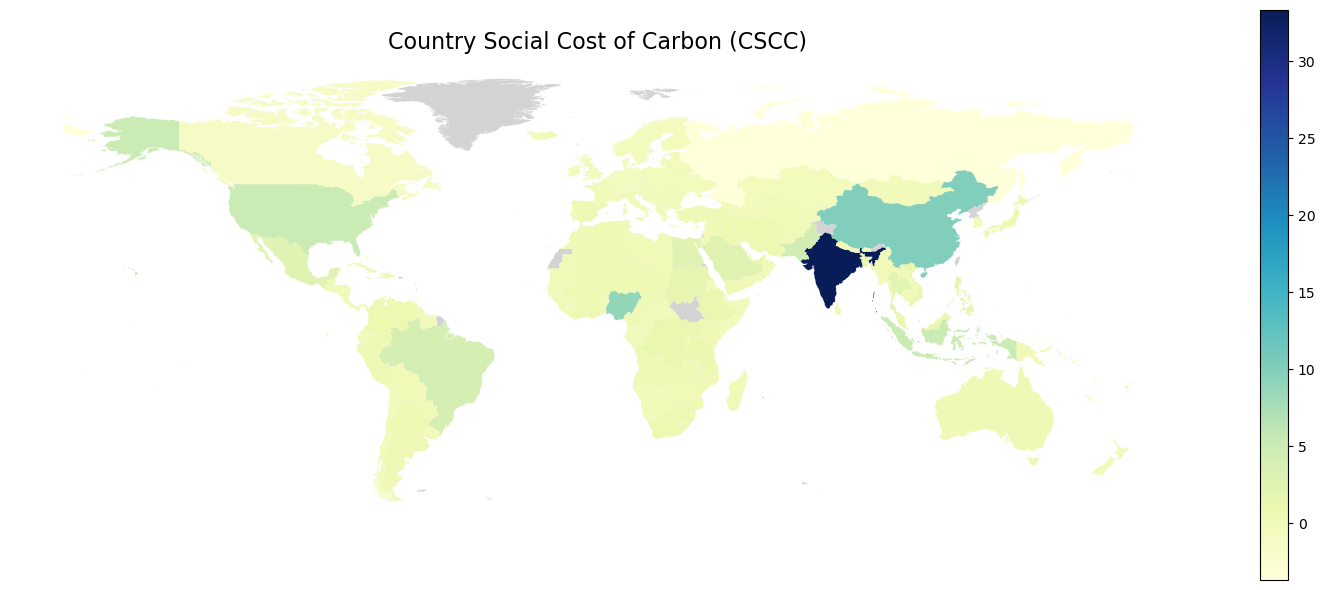

In [33]:
# Ensure country ISO codes are uppercase and match with wealth_df
world["iso"] = world["iso3"].str.upper()

# Merge the GeoDataFrame with the CSCC data from wealth_df
choropleth_df = world.merge(
    wealth_df[["iso", "CSCC"]], left_on="iso", right_on="iso", how="left"
)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
choropleth = choropleth_df.plot(
    column="CSCC",
    cmap="YlGnBu",
    legend=True,
    linewidth=0.2,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Add title and format
ax.set_title("Country Social Cost of Carbon (CSCC)", fontsize=16)
ax.set_axis_off()

# Show the map
plt.tight_layout()

# Save the plot as JPG
plt.savefig(imgDir + "CSCC_map.jpg", format="jpg")

plt.show()

## 2. Discussion: Showcasing Results

### a) Net Wealth Transfer (NWT)

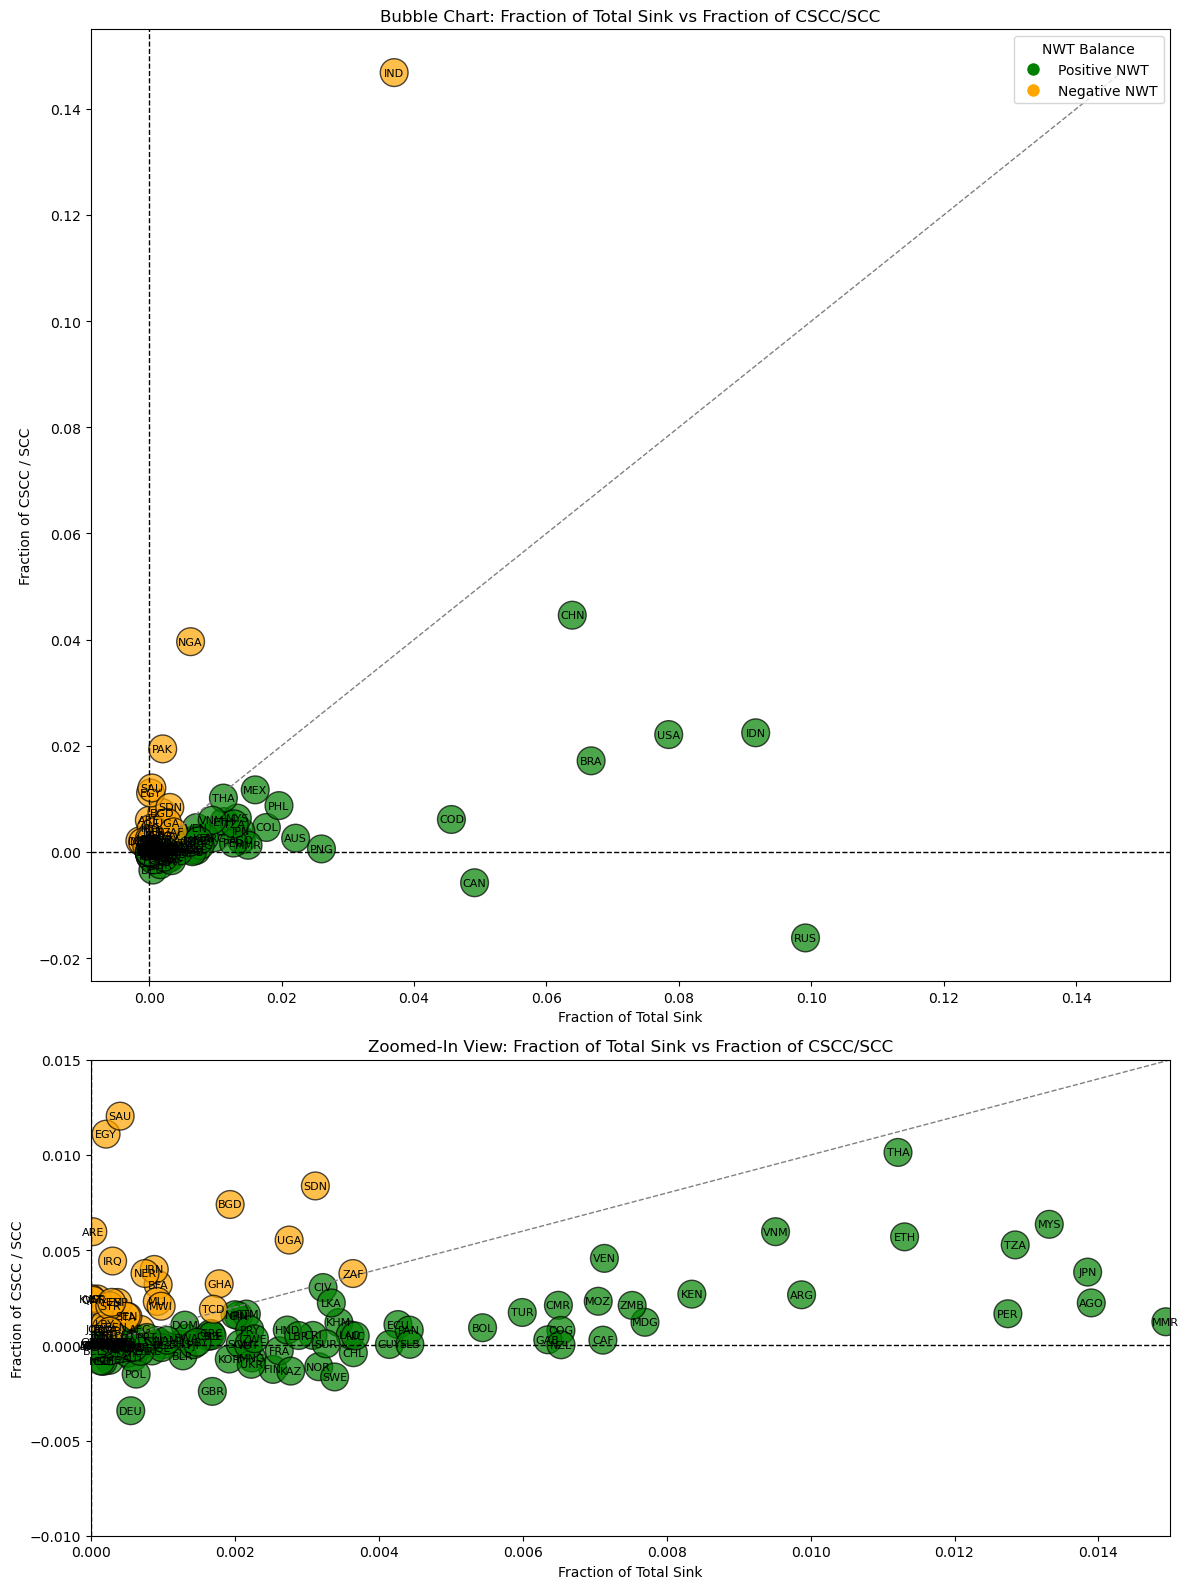

In [34]:
# Calculate fractions for X and Y axes
wealth_df["Sink_Fraction"] = wealth_df["SLAND"] / wealth_df["SLAND"].sum()  # X-axis
wealth_df["CSCC_Fraction"] = wealth_df["CSCC"] / wealth_df["CSCC"].sum()  # Y-axis

# Filter the DataFrame to include only rows with non-NaN values for CSCC_Fraction and Sink_Fraction
plot_df = wealth_df.dropna(
    subset=["CSCC_Fraction", "Sink_Fraction"]
).copy()  # Use `.copy()` to avoid warnings

# Assign fixed bubble size
fixed_bubble_size = 400  # Adjust this value to control bubble size
plot_df["Bubble_Size"] = fixed_bubble_size


# Define colors based on NWT
plot_df["Color"] = np.where(
    plot_df["SLAND_NWT"] > 0, "green", "orange"
)  # Green for positive, orange for negative

# Define zoomed range
zoom_x_min, zoom_x_max = 0.0, 0.015
zoom_y_min, zoom_y_max = -0.01, 0.015

# Filter data for zoomed range
zoom_df = plot_df[
    (plot_df["Sink_Fraction"] >= zoom_x_min)
    & (plot_df["Sink_Fraction"] <= zoom_x_max)
    & (plot_df["CSCC_Fraction"] >= zoom_y_min)
    & (plot_df["CSCC_Fraction"] <= zoom_y_max)
]

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 16), gridspec_kw={"height_ratios": [2, 1]})

# Main plot
scatter_main = axs[0].scatter(
    plot_df["Sink_Fraction"],
    plot_df["CSCC_Fraction"],
    s=plot_df["Bubble_Size"],  # Fixed bubble size
    c=plot_df["Color"],  # Color by NWT values
    alpha=0.7,
    edgecolor="k",
)
# Annotations for main plot
for _, row in plot_df.iterrows():
    axs[0].text(
        row["Sink_Fraction"],
        row["CSCC_Fraction"],
        row["iso"],
        fontsize=8,
        ha="center",
        va="center",
    )

# Add a 45° dashed line to the main plot
max_value_main = max(plot_df["Sink_Fraction"].max(), plot_df["CSCC_Fraction"].max())
axs[0].plot(
    [0, max_value_main],
    [0, max_value_main],
    linestyle="--",
    color="gray",
    linewidth=1,
    label="45° Line",
)

# Formatting main plot
axs[0].set_xlabel("Fraction of Total Sink")
axs[0].set_ylabel("Fraction of CSCC / SCC")
axs[0].set_title("Bubble Chart: Fraction of Total Sink vs Fraction of CSCC/SCC")
axs[0].axhline(
    0, color="black", linestyle="--", linewidth=1
)  # Horizontal reference line
axs[0].axvline(0, color="black", linestyle="--", linewidth=1)  # Vertical reference line

# Add legend to main plot
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="green",
        markersize=10,
        label="Positive NWT",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="orange",
        markersize=10,
        label="Negative NWT",
    ),
]
axs[0].legend(handles=legend_elements, title="NWT Balance", loc="upper right")

# Zoomed-in plot
scatter_zoom = axs[1].scatter(
    zoom_df["Sink_Fraction"],
    zoom_df["CSCC_Fraction"],
    s=zoom_df["Bubble_Size"],
    c=zoom_df["Color"],
    alpha=0.7,
    edgecolor="k",
)
# Annotations for zoomed-in plot
for _, row in zoom_df.iterrows():
    axs[1].text(
        row["Sink_Fraction"],
        row["CSCC_Fraction"],
        row["iso"],
        fontsize=8,
        ha="center",
        va="center",
    )

# Add a 45° dashed line to the zoomed-in plot
max_value_zoom = max(zoom_x_max, zoom_y_max)
axs[1].plot(
    [0, max_value_zoom],
    [0, max_value_zoom],
    linestyle="--",
    color="gray",
    linewidth=1,
    label="45° Line",
)

# Formatting zoomed-in plot
axs[1].set_xlim(zoom_x_min, zoom_x_max)
axs[1].set_ylim(zoom_y_min, zoom_y_max)
axs[1].set_xlabel("Fraction of Total Sink")
axs[1].set_ylabel("Fraction of CSCC / SCC")
axs[1].set_title("Zoomed-In View: Fraction of Total Sink vs Fraction of CSCC/SCC")
axs[1].axhline(
    0, color="black", linestyle="--", linewidth=1
)  # Horizontal reference line
axs[1].axvline(0, color="black", linestyle="--", linewidth=1)  # Vertical reference line

# Adjust layout and show
plt.tight_layout()
# Save the plot as JPG
plt.savefig(imgDir + "bubble_plot.jpg", format="jpg")
plt.show()

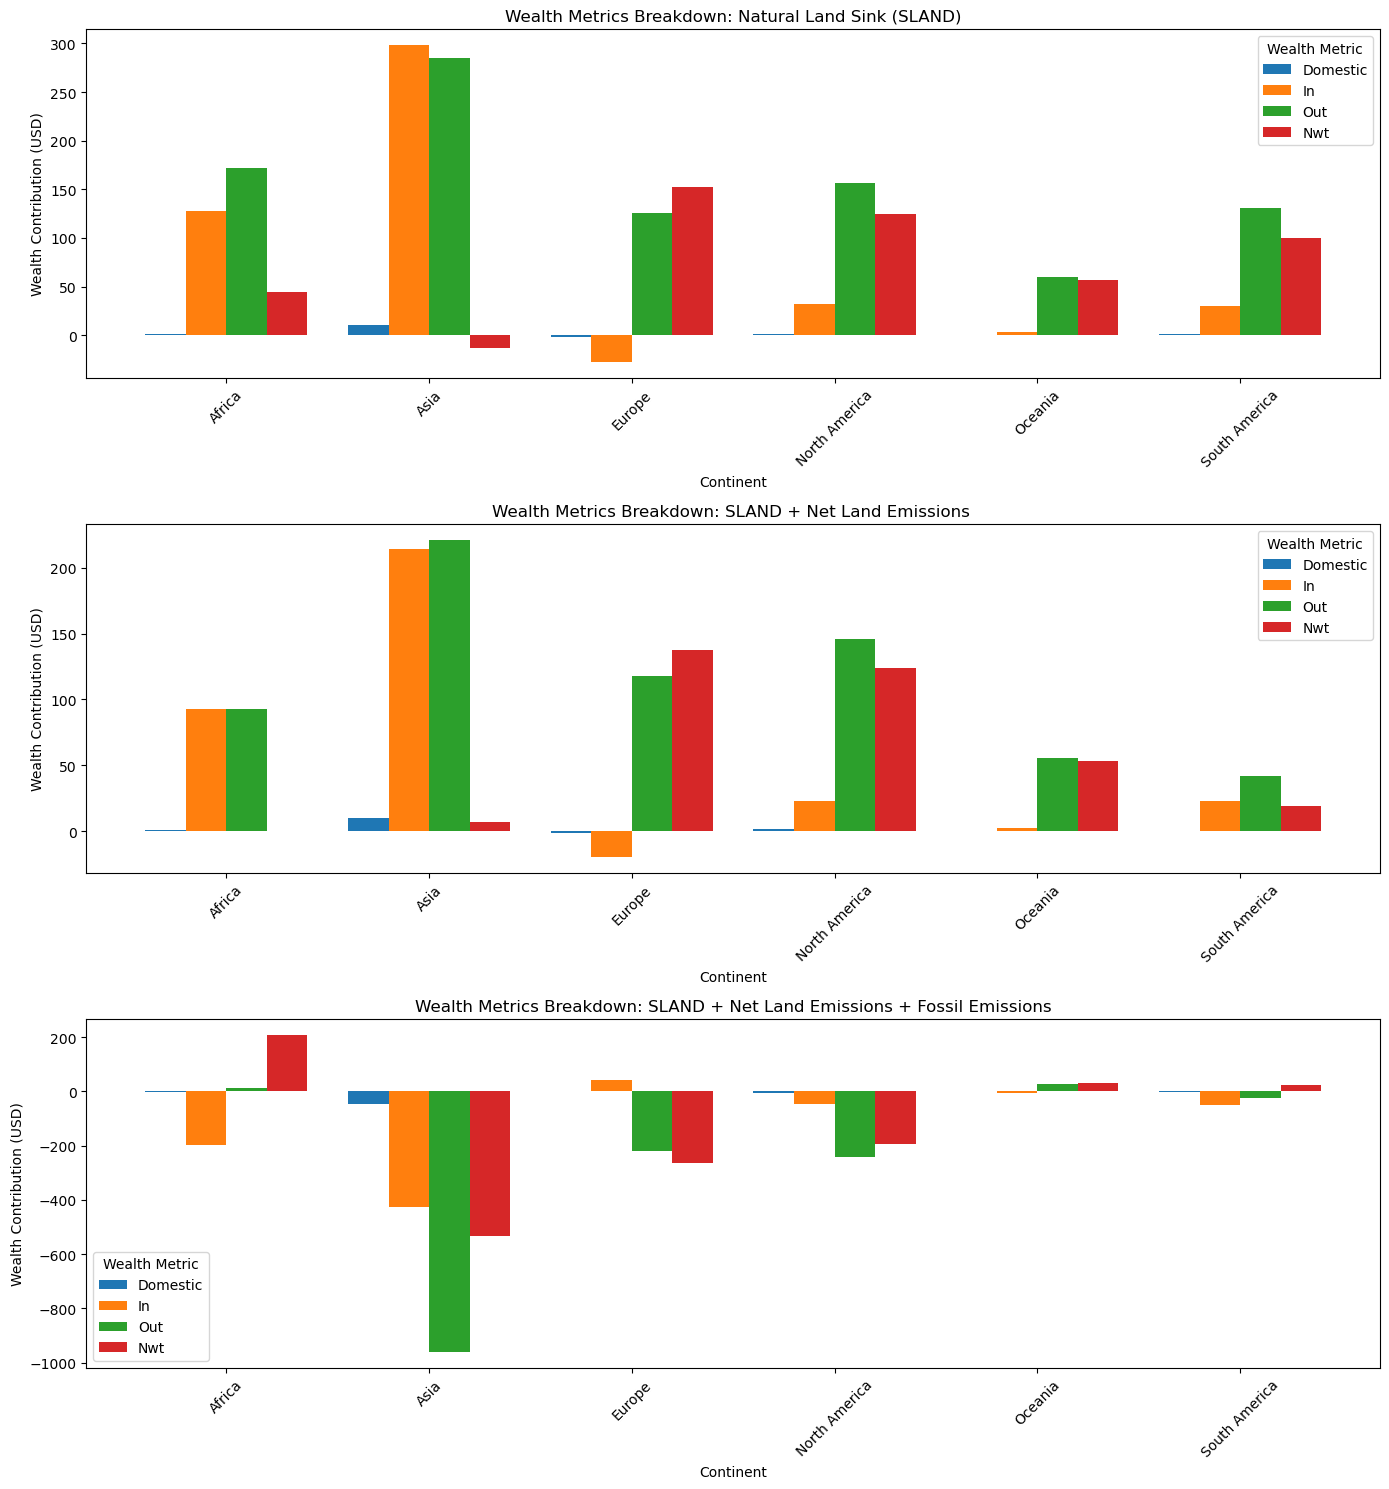

In [35]:
# Flux descriptions (dictionary)
flux_descriptions = {
    "SLAND": "Natural Land Sink (SLAND)",
    "F_ab": "SLAND + Net Land Emissions ",
    "F_abc": "SLAND + Net Land Emissions + Fossil Emissions",
}
# Group wealth metrics by continent


fluxes = ["SLAND", "F_ab", "F_abc"]  # Sland, Sland + Eluc, Sland + Eluc + Efos


wealth_metrics = ["domestic", "in", "out", "NWT"]


grouped_data = {}

for flux in fluxes:
    metrics = [f"{flux}_{metric}" for metric in wealth_metrics]
    grouped = wealth_df.groupby("Continent")[metrics].sum()
    grouped_data[flux] = grouped

# Plot grouped bar chart
fig, axs = plt.subplots(len(fluxes), 1, figsize=(14, 5 * len(fluxes)))

bar_width = 0.2  # Width of each bar
for i, flux in enumerate(fluxes):
    grouped = grouped_data[flux]
    x = np.arange(len(grouped.index))  # X-axis positions for groups (continents)

    # Plot bars for each wealth metric
    for j, metric in enumerate(wealth_metrics):
        axs[i].bar(
            x + j * bar_width,
            grouped[f"{flux}_{metric}"],
            width=bar_width,
            label=metric.capitalize(),
        )

    # Formatting

    axs[i].set_xticks(x + bar_width * (len(wealth_metrics) - 1) / 2)

    axs[i].set_xticklabels(grouped.index, rotation=45)

    axs[i].set_xlabel("Continent")

    axs[i].set_ylabel("Wealth Contribution (USD)")

    axs[i].set_title(f"Wealth Metrics Breakdown: {flux_descriptions[flux]}")

    axs[i].legend(title="Wealth Metric")


# Adjust layout and show plot


plt.tight_layout()


plt.savefig(imgDir + "Wealth_metrics_bar.jpg", format="jpg")


plt.show()

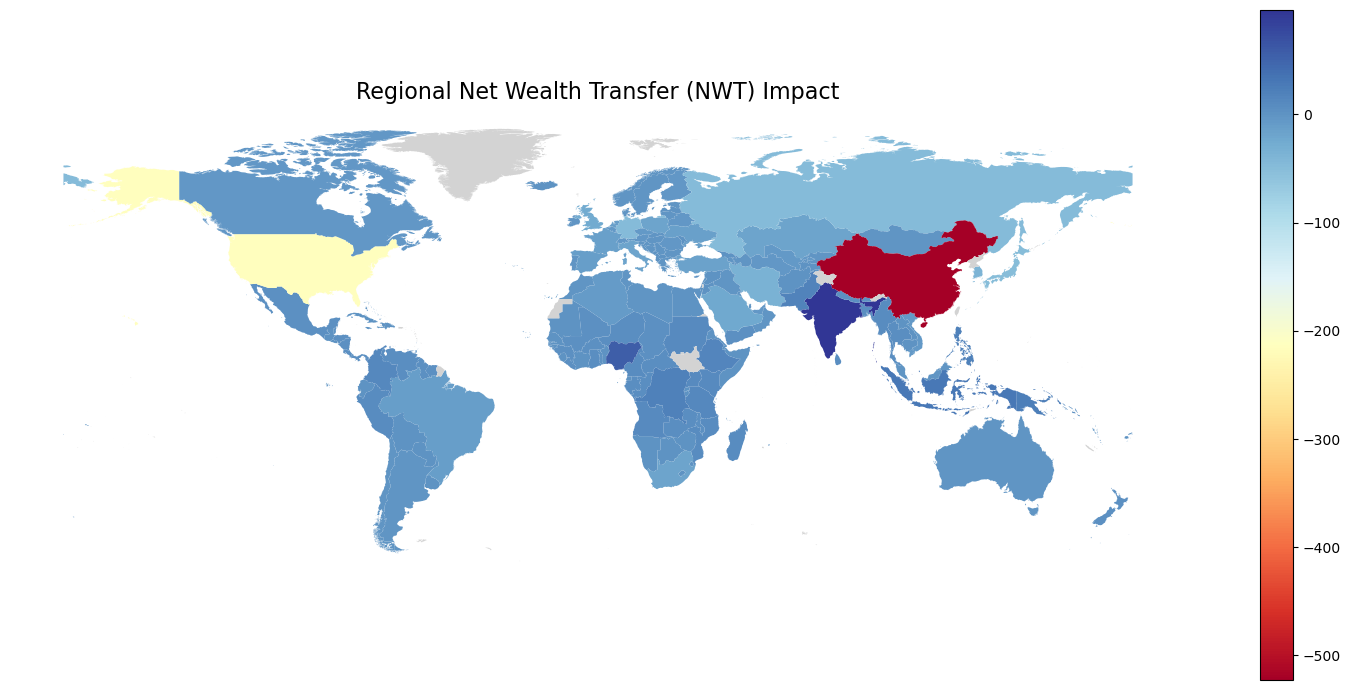

In [36]:
# Merge NWT data with world shapefile
map_df = world.merge(
    wealth_df[["iso", "F_abc_NWT"]], left_on="iso", right_on="iso", how="left"
)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
map = map_df.plot(
    column="F_abc_NWT",  # Column to visualize
    cmap="RdYlBu",  # Diverging colormap for positive/negative values
    legend=True,
    linewidth=0.2,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Add title and format
ax.set_title("Regional Net Wealth Transfer (NWT) Impact", fontsize=16)
ax.set_axis_off()

# Show the map
plt.tight_layout()

plt.savefig(imgDir + "NWT_map.jpg", format="jpg")

plt.show()

### EXKURS:

In [40]:
terrestrial_sink = pd.read_excel(
    rawDir + "Global_Carbon_Budget_2024_v1.0.xlsx",
    sheet_name="Terrestrial Sink",
    header=27,
)  # Row 28 has column names

# Drop column 'C' since it is empty
terrestrial_sink = terrestrial_sink.drop(columns=["Unnamed: 2"])

# View the resulting DataFrame
print(terrestrial_sink.head())

# Filter the DataFrame for the years 2013 to 2022
filtered_terrestrial_sink = terrestrial_sink[
    (terrestrial_sink["Year"] >= 2014) & (terrestrial_sink["Year"] <= 2023)
]

# Calculate the mean of the 'GCB' column for the filtered years
mean_gcb = filtered_terrestrial_sink["GCB"].mean()

   Year       GCB  CABLE-POP  CLASSIC  CLM6.0  DLEM    ED   ELM  IBIS  iMAPLE  \
0  1959  0.368378      -0.27     0.30    1.24  0.50  0.59  0.61  0.50    0.40   
1  1960  1.096426       2.12     0.91    1.93  1.43  0.83  1.50  0.96    1.35   
2  1961  0.845491       1.68     0.73    1.16  1.21  1.86  0.91  0.60    1.22   
3  1962  1.319126       2.03     0.93    1.78  1.70  1.50  1.77  1.03    1.94   
4  1963  0.874709       1.74    -0.24    1.56  1.13  1.09  1.82  0.22    1.21   

   ...     LPJml  LPJwsl   LPX   OCN  Orchidee  SDGVM  VISIT  Unnamed: 23  \
0  ... -0.052431   -1.03  0.25  0.79      0.47   0.25   1.33          NaN   
1  ...  1.398512   -0.25  0.56  1.00      1.09   0.42   1.43          NaN   
2  ...  0.049820   -0.64  0.39  1.44      0.83  -0.72   1.34          NaN   
3  ...  0.992517   -0.12  0.13  1.69      1.51  -0.71   2.15          NaN   
4  ...  0.294180   -0.76  0.19  1.49      0.82  -0.07   2.02          NaN   

   Multi-model mean  Model Spread (sd)  
0        

In [41]:
print(mean_gcb)

3.1861086197281807


## Comparison GCB and Dorgeist

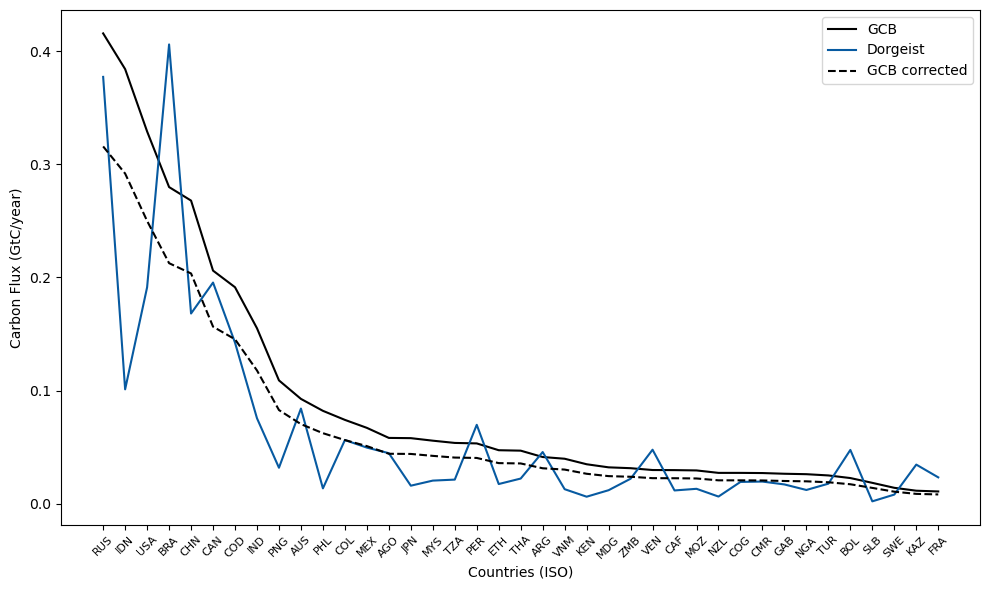

In [ ]:
# Calculate GCB corrected
wealth_df["GCB_corrected"] = wealth_df["SLAND"] * (mean_gcb / SLAND_global)

# Sort data by GCB (SLAND) for consistent plotting
wealth_df_sorted = wealth_df.sort_values(by="SLAND", ascending=False)

# Define the list of countries to include
countries_to_include = [
    "RUS",
    "IDN",
    "USA",
    "BRA",
    "CHN",
    "CAN",
    "COD",
    "IND",
    "PNG",
    "MEX",
    "PHL",
    "COL",
    "PER",
    "ARG",
    "TZA",
    "AGO",
    "AUS",
    "ETH",
    "JPN",
    "MYS",
    "THA",
    "KEN",
    "MOZ",
    "VNM",
    "ZMB",
    "MDG",
    "CAF",
    "BOL",
    "NZL",
    "FRA",
    "VEN",
    "CMR",
    "NGA",
    "COG",
    "TUR",
    "KAZ",
    "SLB",
    "GAB",
    "SWE",
]

# Filter the dataframe for the selected countries
wealth_df_sorted = wealth_df_sorted[wealth_df_sorted["iso"].isin(countries_to_include)]

# Extract data for plotting
countries = wealth_df_sorted["iso"]  # ISO country codes
gcb_values = wealth_df_sorted["SLAND"]
dorgeist_values = wealth_df_sorted["SLAND_dor"]
gcb_corrected_values = wealth_df_sorted["GCB_corrected"]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot GCB (SLAND)
ax.plot(countries, gcb_values, label="GCB", color="black", linestyle="-", linewidth=1.5)

# Plot Dorgeist (SLAND_dor)
ax.plot(
    countries,
    dorgeist_values,
    label="Dorgeist",
    color="#075aa1",
    linestyle="-",
    linewidth=1.5,
)

# Plot GCB corrected
ax.plot(
    countries,
    gcb_corrected_values,
    label="GCB corrected",
    color="black",
    linestyle="--",
    linewidth=1.5,
)

# Formatting
ax.set_xlabel("Countries (ISO)")
ax.set_ylabel("Carbon Flux (GtC/year)")
# ax.set_title("Comparison of GCB, Dorgeist, and GCB Corrected")
ax.set_xticks(np.arange(len(countries)))
ax.set_xticklabels(countries, rotation=45, fontsize=8)
ax.legend()

# Adjust layout and show
plt.tight_layout()

plt.savefig(imgDir + "Comparison_GCB_Dorgeist.jpg", format="jpg")

plt.show()

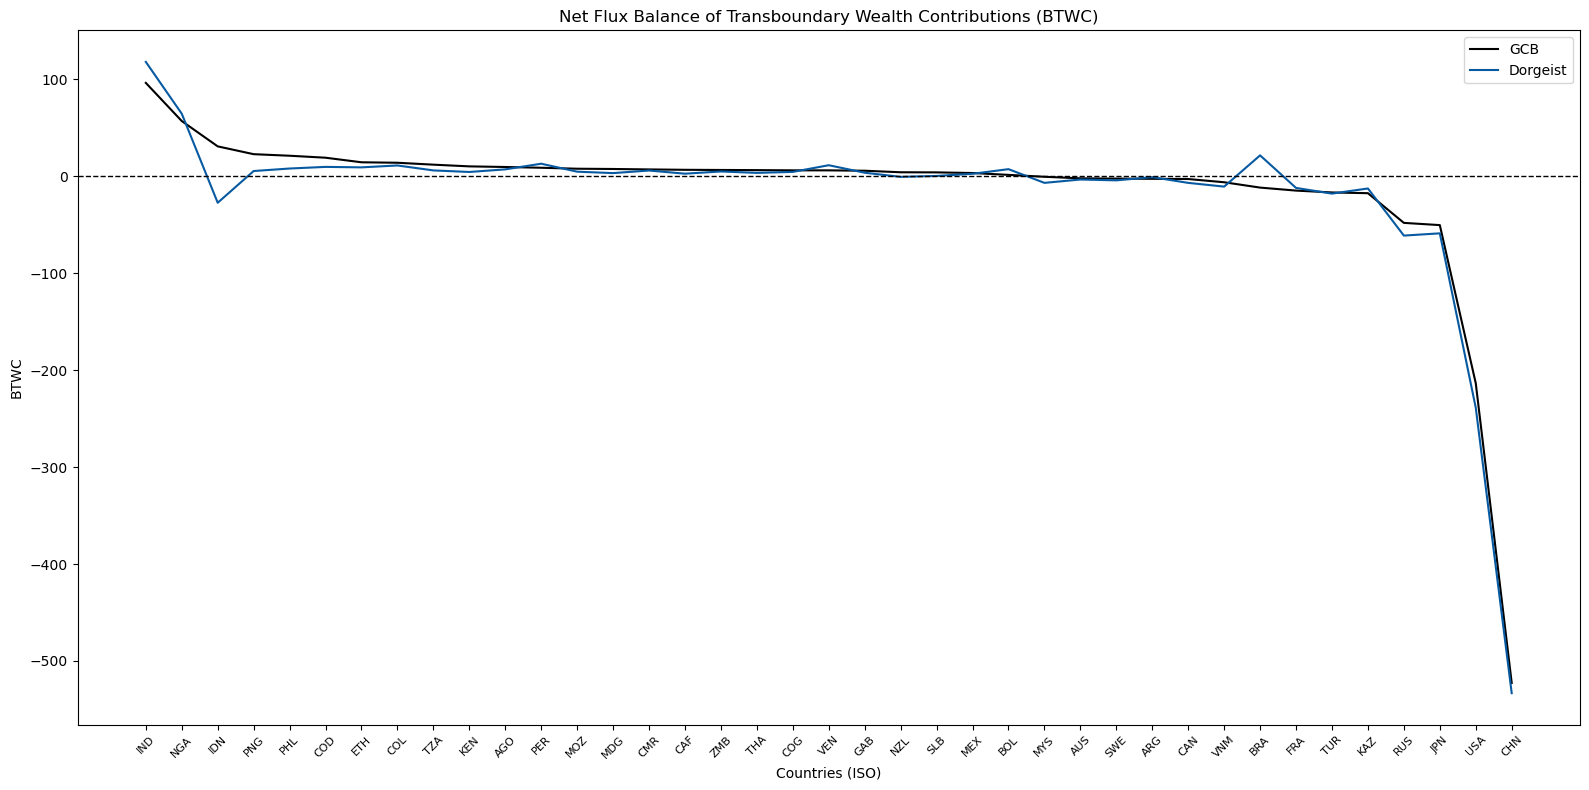

In [ ]:
# Sort the filtered data by F_abc_NWT for consistent plotting
wealth_df_NWT = wealth_df_sorted.sort_values(by="F_abc_NWT", ascending=False)

# Extract data for plotting
countries = wealth_df_NWT["iso"]  # ISO country codes
f_abc_nwt = wealth_df_NWT["F_abc_NWT"]
f_abc_dor_nwt = wealth_df_NWT["F_abc_dor_NWT"]

# Plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Plot F_abc_NWT
ax.plot(countries, f_abc_nwt, label="GCB", color="black", linestyle="-", linewidth=1.5)

# Plot F_abc_dor_NWT
ax.plot(
    countries,
    f_abc_dor_nwt,
    label="Dorgeist",
    color="#075aa1",
    linestyle="-",
    linewidth=1.5,
)

# Formatting
ax.set_xticks(np.arange(len(countries)))
ax.set_xticklabels(countries, rotation=45, fontsize=8)
ax.set_xlabel("Countries (ISO)")
ax.set_ylabel("BTWC")
ax.set_title("Net Flux Balance of Transboundary Wealth Contributions (BTWC)")
ax.axhline(0, color="black", linestyle="--", linewidth=1)  # Reference line at zero
ax.legend()

# Adjust layout and show
plt.tight_layout()

plt.savefig(imgDir + "BTWC_GCB_Dorgeist.jpg", format="jpg")

plt.show()